# PROJET 10 : DETECTEZ LES FAUX BILLETS AVEC R OU PYTHON

Nous sommes une entreprise française spécialisée dans la data, ayant décroché une prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM).

Le but de l'analyse est de déterminer le type de chacun des billets à partir des dimensions.

2 grands axes de travail :

- Utiliser la régression linéaire multiple pour remplir les valeurs manquantes
- Utiliser la Régression logistique pour prédire le type de billet.


## 1.Importation des librairies et de la table de données

In [1]:
# Importation des librairies

import pandas as pd
import numpy as np
import seaborn as sns

# Librairies statistiques et graphiques:

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importation des données

billets = pd.read_csv("billets.csv", sep=';')
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


## 2.Analyse exploratoire

Les variables :

is_genuine : la nature du billet: True pour un vrai billet et False pour un faux billet

diagonal : la diagonale du billet (en mm)

height_left : la hauteur du billet (mesurée sur le côté gauche, en mm)

height_right : la hauteur du billet (mesurée sur le côté droit, en mm)

margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm)

margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)

length : la longueur du billet (en mm)




### 2.1. Variables individuelles

In [3]:
# Informations sur les variables

billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [4]:
# Valeurs manquantes ?

billets.isnull().sum()

,0
is_genuine,0
diagonal,0
height_left,0
height_right,0
margin_low,37
margin_up,0
length,0


In [5]:
# Description des variables

billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [6]:
# Nombre de vrais billets et de faux billets

billets['is_genuine'].value_counts()

,count
is_genuine,
True,1000
False,500


In [7]:
# Valeurs manquantes dans "True" et dans "False"?

billets.loc[(billets['margin_low'].isna()),:'is_genuine'].value_counts()


,count
is_genuine,
True,29
False,8


In [8]:
# Présence des doublons  ?

billets.duplicated().sum()

0

### 2.2.Représentations graphiques générales

<Axes: ylabel='count'>

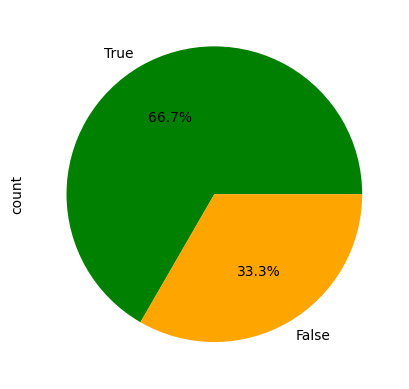

In [9]:
# Graphique

colors = ( "green", "orange")
billets["is_genuine"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=colors )

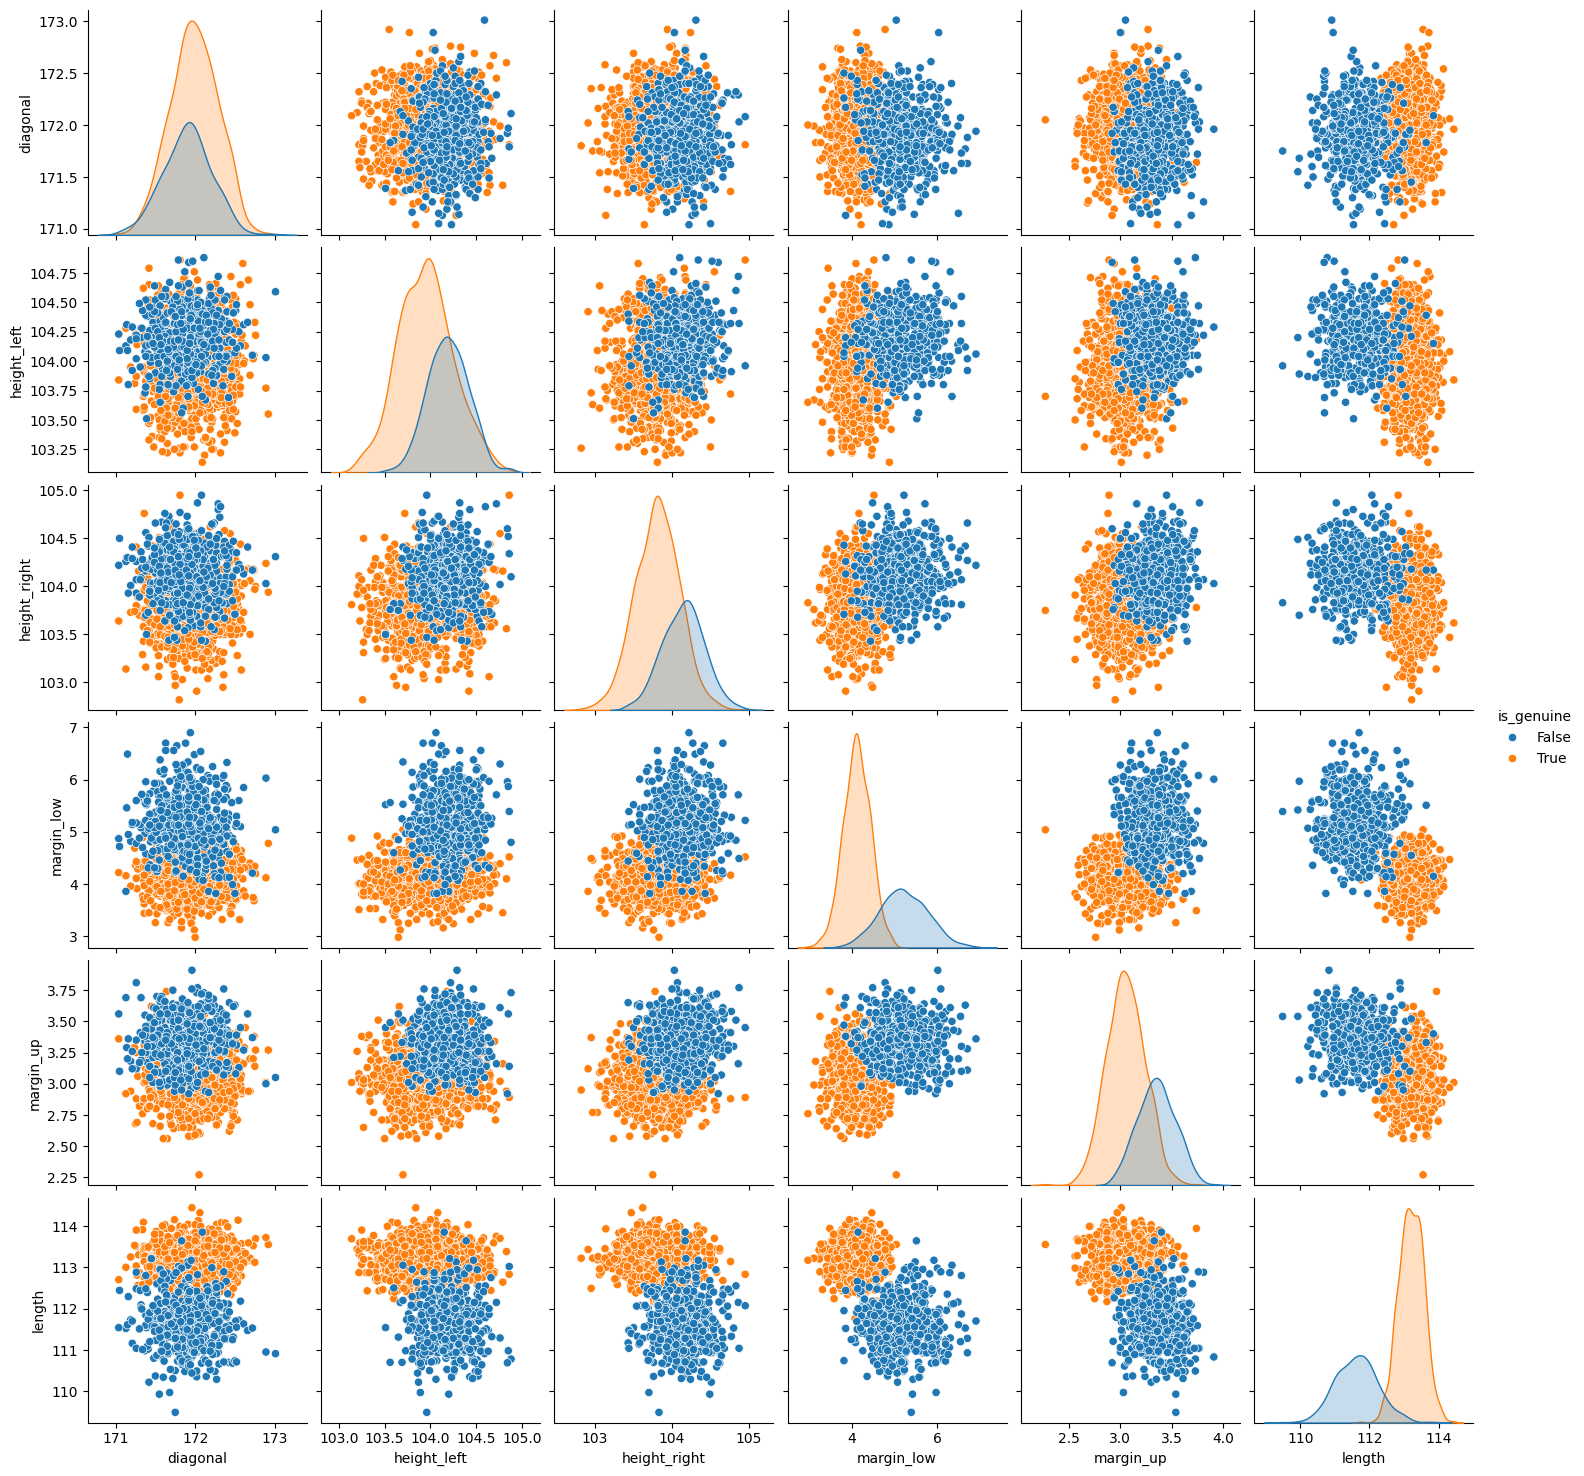

In [10]:
# Représentations graphiques

sns.pairplot(billets, hue = 'is_genuine')

### 2.3. Distributions des variables

In [11]:
# df avec les vrais billets

vrais = billets.loc[billets['is_genuine'] == True]
vrais.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.000000,1000.000000,1000.00000,971.000000,1000.00000,1000.000000
mean,171.987080,103.949130,103.80865,4.116097,3.05213,113.202430
std,0.300441,0.300231,0.29157,0.319124,0.18634,0.359552
min,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,171.790000,103.740000,103.61000,3.905000,2.93000,112.950000
50%,171.990000,103.950000,103.81000,4.110000,3.05000,113.205000
75%,172.200000,104.140000,104.00000,4.340000,3.18000,113.460000
max,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


In [12]:
# df avec les vrais billets

faux = billets.loc[billets['is_genuine'] == False]
faux.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.000000,500.000000,500.000000,492.000000,500.000000,500.000000
mean,171.901160,104.190340,104.143620,5.215935,3.350160,111.630640
std,0.306861,0.223758,0.270878,0.553531,0.180498,0.615543
min,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,171.910000,104.180000,104.160000,5.190000,3.350000,111.630000
75%,172.092500,104.332500,104.320000,5.592500,3.472500,112.030000
max,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


In [13]:
# Distribution de la variable "diagonal"

from scipy.stats import norm

# Figure
fig = go.Figure()

# Courbe de Gauss vrai_billet
xv = np.linspace(171,173)
mean_v = np.mean(vrais['diagonal'])
std_v = np.std(vrais['diagonal'])
yv = norm.pdf(xv, mean_v, std_v)*50
fig.add_trace(go.Scatter(x=xv, y=yv, name='Courbe de Gauss True'))

# Courbe de Gauss faux_billet
xf = np.linspace(171,173.05)
mean_f = np.mean(faux['diagonal'])
std_f = np.std(faux['diagonal'])
yf = norm.pdf(xf, mean_f, std_f)*25
fig.add_trace(go.Scatter(x=xf, y=yf, name='Courbe de Gauss False'))

# Histogramme
fig.add_trace(go.Histogram(x=vrais['diagonal'], name='True'))
fig.add_trace(go.Histogram(x=faux['diagonal'], name='False'))

# Titres et visuel
fig.update_layout(title='Graphique 3: Distribution de la variable diagonal')

fig.update_traces(opacity=0.75)
fig.show()

In [14]:
# Distribution de la variable "height_left":

# Figure
fig = go.Figure()

# Courbe de Gauss vrai_billet
xv = np.linspace(103,105)
mean_v = np.mean(vrais['height_left'])
std_v = np.std(vrais['height_left'])
yv = norm.pdf(xv, mean_v, std_v)*50
fig.add_trace(go.Scatter(x=xv, y=yv, name='Courbe de Gauss True'))

# Courbe de Gauss faux_billet
xf = np.linspace(103,105)
mean_f = np.mean(faux['height_left'])
std_f = np.std(faux['height_left'])
yf = norm.pdf(xf, mean_f, std_f)*25
fig.add_trace(go.Scatter(x=xf, y=yf, name='Courbe de Gauss False'))

# Histogramme
fig.add_trace(go.Histogram(x=vrais['height_left'], name='True'))
fig.add_trace(go.Histogram(x=faux['height_left'], name='False'))

# Titres et visuel
fig.update_layout(title='Graphique 4 : Distribution de la variable height_left')

fig.update_traces(opacity=0.75)
fig.show()

In [15]:
# Distribution de la variable "height_right"

from scipy.stats import norm

# Figure
fig = go.Figure()

# Courbe de Gauss vrai_billet
xv = np.linspace(103,105)
mean_v = np.mean(vrais['height_right'])
std_v = np.std(vrais['height_right'])
yv = norm.pdf(xv, mean_v, std_v)*50
fig.add_trace(go.Scatter(x=xv, y=yv, name='Courbe de Gauss True'))

# Courbe de Gauss faux_billet
xf = np.linspace(103,105)
mean_f = np.mean(faux['height_right'])
std_f = np.std(faux['height_right'])
yf = norm.pdf(xf, mean_f, std_f)*25
fig.add_trace(go.Scatter(x=xf, y=yf, name='Courbe de Gauss False'))

# Histogramme
fig.add_trace(go.Histogram(x=vrais['height_right'], name='True'))
fig.add_trace(go.Histogram(x=faux['height_right'], name='False'))

# Titres et visuel
fig.update_layout(title='Graphique 5 : Distribution de la variable height_right')

fig.update_traces(opacity=0.75)
fig.show()

In [16]:
# Distribution de la variable "margin_low":

# Figure
fig = go.Figure()

# Courbe de Gauss vrai_billet
xv = np.linspace(2.9,5.05)
mean_v = np.mean(vrais['margin_low'])
std_v = np.std(vrais['margin_low'])
yv = norm.pdf(xv, mean_v, std_v)*100
fig.add_trace(go.Scatter(x=xv, y=yv, name='Courbe de Gauss True'))

# Courbe de Gauss faux_billet
xf = np.linspace(3.8,6.90)
mean_f = np.mean(faux['margin_low'])
std_f = np.std(faux['margin_low'])
yf = norm.pdf(xf, mean_f, std_f)*50
fig.add_trace(go.Scatter(x=xf, y=yf, name='Courbe de Gauss False'))

# Histogramme
fig.add_trace(go.Histogram(x=vrais['margin_low'], name='True'))
fig.add_trace(go.Histogram(x=faux['margin_low'], name='False'))

# Titres et visuel
fig.update_layout(title='Graphique 6 : Distribution de la variable margin_low')

fig.update_traces(opacity=0.75)
fig.show()

In [17]:
# Distribution de la variable "margin_up":

# Figure
fig = go.Figure()

# Courbe de Gauss vrai_billet
xv = np.linspace(2.25,3.75)
mean_v = np.mean(vrais['margin_up'])
std_v = np.std(vrais['margin_up'])
yv = norm.pdf(xv, mean_v, std_v)*50
fig.add_trace(go.Scatter(x=xv, y=yv, name='Courbe de Gauss True'))

# Courbe de Gauss faux_billet
xf = np.linspace(2.9,3.95)
mean_f = np.mean(faux['margin_up'])
std_f = np.std(faux['margin_up'])
yf = norm.pdf(xf, mean_f, std_f)*25
fig.add_trace(go.Scatter(x=xf, y=yf, name='Courbe de Gauss False'))

# Histogramme
fig.add_trace(go.Histogram(x=vrais['margin_up'], name='True'))
fig.add_trace(go.Histogram(x=faux['margin_up'], name='False'))

# Titres et visuel
fig.update_layout(title='Graphique 7 : Distribution de la variable margin_up')

fig.update_traces(opacity=0.75)
fig.show()

In [18]:
# Distribution de la variable "length":

# Figure
fig = go.Figure()

# Courbe de Gauss df_vrai_billets:
xv = np.linspace(111.75,114.45)
mean_v = np.mean(vrais['length'])
std_v = np.std(vrais['length'])
yv = norm.pdf(xv, mean_v, std_v)*100
fig.add_trace(go.Scatter(x=xv, y=yv, name='Courbe de Gauss True'))

# Courbe de Gauss df_faux_billets:
xf = np.linspace(109.45,113.9)
mean_f = np.mean(faux['length'])
std_f = np.std(faux['length'])
yf = norm.pdf(xf, mean_f, std_f)*50
fig.add_trace(go.Scatter(x=xf, y=yf, name='Courbe de Gauss False'))

# Histogramme
fig.add_trace(go.Histogram(x=vrais['length'], name='True'))
fig.add_trace(go.Histogram(x=faux['length'], name='False'))

# Titres et visuel
fig.update_layout(title='Graphique 8 : Distribution de la variable length')

fig.update_traces(opacity=0.75)
fig.show()

### 2.4. Matrice de corrélation

Text(0.5, 1.0, 'Graphique 9 : Corrélation entre les variables')

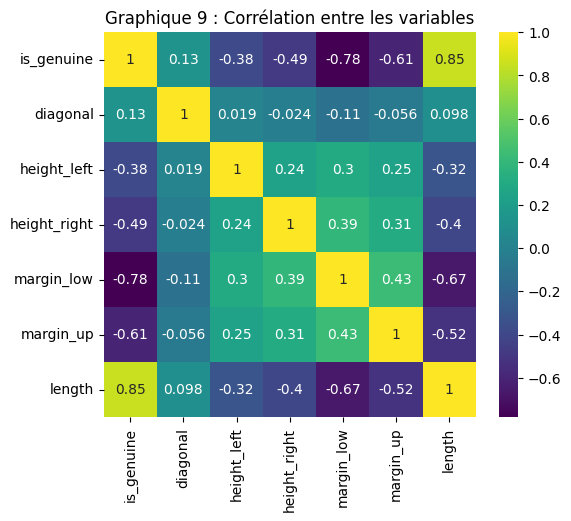

In [19]:
# Carte de chaleur / Heatmap/ Matrice de corrélations entre les variables

plt.figure(figsize=(6, 5))
sns.heatmap(billets.corr(), cmap = 'viridis', annot = True)
plt.title('Graphique 9 : Corrélation entre les variables')

On observe que "margin_low" est :

- Très négativement correlé avec "is_geniune"
- Positivement correlé avec "margin_up"
- Négativement corrélé avec "length"

Faisons une représentation graphique en nuages de points, on voit mieux les corrélations entre ces variables, avec le type de billet bien représenté.

### 2.5. Visualisation des variabes correlées



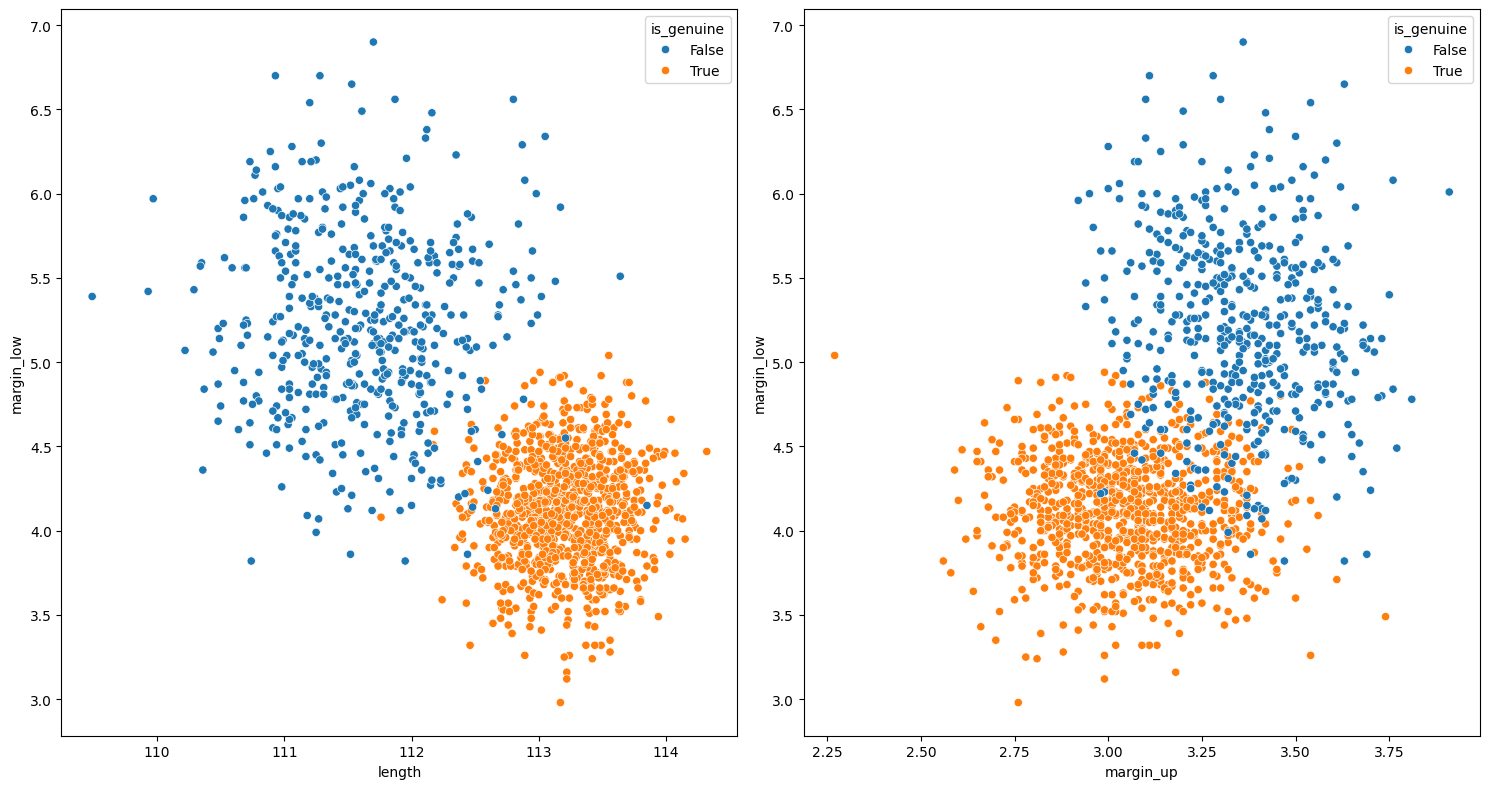

In [20]:
# Nuage de points de 'margin_low' en fonction des variables correlées /10
# Représentation graphique le nuage de points 'margin_low' en fonction de 'length' et 'margin_up'

f, axs = plt.subplots(1,2, figsize=(15,8))
sns.scatterplot(data= billets, x='length', y='margin_low', hue='is_genuine', ax=axs[0])
sns.scatterplot(data=billets, x='margin_up', y='margin_low', hue='is_genuine', ax=axs[1])
f.tight_layout()
plt.show()

Ces 2 graphiques des nuages de points donnent une tendance ou un alignement proche d'une droite descendante avec peu d'erreurs pour l'un et montante.

## 3.Travail préliminaire

### 3.1 Séparation des données en 2 dataframes disctincts (sans VM et avec VM)


In [21]:
# Nouveau DataFrame sans valeurs manquantes (NaN)

billets_sansvm = billets.dropna()
billets_sansvm.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [22]:
# Nouveau DataFrame avec valeurs manquantes (NaN)

billets_avecvm = billets[billets['margin_low'].isna()]
billets_avecvm.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


### 3.2 Retrait des variables non significatives (méthode backward)

In [23]:
# Méthode Backward automatique sur "billets_sansvm"

# Code du cours d'OpenClassroom (TP 2 : Pratiquez la régression linéaire multiple sur le jeu de données de l'ozone)

def backward_selected(data, response):

    remaining = set(data._get_numeric_data().columns)
    if response in remaining:
        remaining.remove(response)
    cond = True

    while remaining and cond:
        formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
        print('_______________________________')
        print(formula)
        model = smf.ols(formula, data).fit()
        score = model.pvalues[1:]
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
            remaining.remove(toRemove.index[0])
        else:
            cond = False
            print('is the final model !')
        print('')
    print(model.summary())

    return model

In [24]:
columns = ['margin_low', 'is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']
reg_backward = backward_selected(billets_sansvm[columns], 'margin_low')

_______________________________
margin_low ~ margin_up + diagonal + height_left + height_right + is_genuine + length + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ margin_up + diagonal + height_left + height_right + is_genuine + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ margin_up + height_left + height_right + is_genuine + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ margin_up + height_left + is_genuine + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ margin_up + is_genuine + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

In [25]:
# Ou encore régresser linéairement 'margin_low' en fonction des autres variables

reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=billets_sansvm).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Fri, 06 Sep 2024   Prob (F-statistic):          4.75e-299
Time:                        07:46:03   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

In [26]:
# Nouvelle itération sans 'length'

reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     469.2
Date:                Fri, 06 Sep 2024   Prob (F-statistic):          2.12e-300
Time:                        07:46:04   Log-Likelihood:                -774.15
No. Observations:                1463   AIC:                             1560.
Df Residuals:                    1457   BIC:                             1592.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.4247      7

In [27]:
# Nouvelle itération sans 'diagonal'

reg_multi = smf.ols('margin_low~is_genuine+height_left+height_right+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     586.8
Date:                Fri, 06 Sep 2024   Prob (F-statistic):          8.76e-302
Time:                        07:46:04   Log-Likelihood:                -774.21
No. Observations:                1463   AIC:                             1558.
Df Residuals:                    1458   BIC:                             1585.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3902      5

In [28]:
# Nouvelle itération sans 'height_right'

reg_multi = smf.ols('margin_low~is_genuine+height_left+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     782.5
Date:                Fri, 06 Sep 2024   Prob (F-statistic):          3.63e-303
Time:                        07:46:04   Log-Likelihood:                -774.45
No. Observations:                1463   AIC:                             1557.
Df Residuals:                    1459   BIC:                             1578.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.9104      4

In [29]:
# Nouvelle itération sans 'height_left'

reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Fri, 06 Sep 2024   Prob (F-statistic):          1.24e-304
Time:                        07:46:04   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.9263      0

R2 et R2 ajusté gardent la même valeur, donc le retrait de ces variables non significatives ne changent rien au modèle.
A présent, utilisons donc notre df sans VM pour entraîner le modèle, pour par la suite prédire les VM sur le 2e df avec VM.

### 3.3 Vérification des conditions d'application de la régression linéaire multiple

In [30]:
# Les variables prédictives

x_train = billets_sansvm.drop("margin_low", axis=1)
y_train = billets_sansvm["margin_low"]

#### a. La colinéarité

Calcul des facteurs d'inflation de la variance (VIF) :

Toute variable avec un VIF supérieur à 10 indique une forte colinéarité avec les autres variables explicatives.


In [31]:
# Test statistique ( VIF)

from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5938854494007753, 1.5938854494007746]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

#### b. La normalité des résidus

Elle signifie que les erreurs sont distribués symétriquement autour de zéro, sans asymétrie ni aplatissement i.e. les résidus sont distribués selon la loi normale. Cette hypothèse implique que le modèle capture les principales tendances et sources de variation des données et que les erreurs sont aléatoires et indépendantes.

In [32]:
# Test de Shapiro-Wilk

from scipy.stats import shapiro

shapiro_test = shapiro(reg_multi.resid)
print(f'Test de Shapiro-Wilk: {shapiro_test}')

Test de Shapiro-Wilk: ShapiroResult(statistic=0.9936252795074536, pvalue=6.21444675041755e-06)


In [33]:
# Test d'Aderson-Darling

from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from scipy.stats import t
from scipy.stats import norm

La p-value du test d'Aderson-Darling vaut 4.8613414248955766e-05


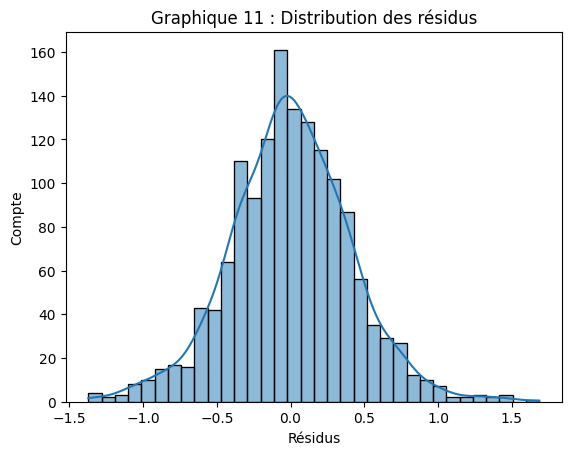

In [34]:
# Creation d'une colonne contenant les residus:

billets_sansvm["margin_low_pred"] = reg_multi.predict(x_train)
billets_sansvm["residual"] = billets_sansvm["margin_low"] - billets_sansvm["margin_low_pred"]

# Normalite:

print("La p-value du test d'Aderson-Darling vaut", normal_ad(billets_sansvm["residual"])[1])

# Graphique:
sns.histplot(billets_sansvm["residual"], kde=True)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Graphique 11 : Distribution des résidus")
plt.show()

Ici, l'hypothèse de normalité est validée (p-value < 0.05), les résidus suivent une distribution normale

#### c. L'homoscédasticité

Le test statistique de White permet de vérifier si la variance des erreurs d'un modèle de régression est constante pour toutes les valeurs des variables independantes.Vérifié si p-value < 5%


{'Test Statistic': 166.92896597830782, 'p-value': 4.769905016348369e-35, 'F-Statistic': 46.946198550777005, 'F-Test p-value': 3.7024551237822514e-37}


Text(0.5, 1.0, 'Graphique 12 : Homoscédasticité')

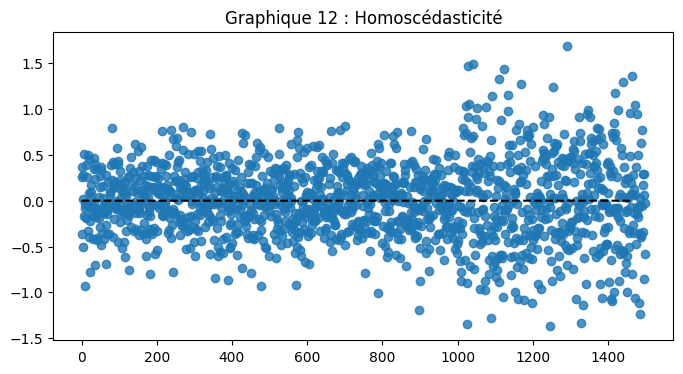

In [35]:
# Homoscedasticite : Test de White

from statsmodels.stats.diagnostic import het_white

reg_multi.resid
white_test = het_white(reg_multi.resid, reg_multi.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

# Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(x=billets_sansvm.index, y=billets_sansvm["residual"], alpha=0.8)
plt.plot(np.repeat(0, len(billets_sansvm.index)+2), color="black", linestyle='--')
plt.title("Graphique 12 : Homoscédasticité")

L'hypothèse d'homoscédasticité de notre régression linéaire est donc considérée comme vérifiée puisque p-valeur ici est très inférieure à  5 %.
La constance de la variance des résidus peut être évaluée par un nuage de point des résidus en fonctions des valeurs prédites. Ce nuage de points ne doit pas avoir de forme particulière, c'est à dire des résidus homogènes autour de zéro (généralement compris entre -2 et 2). c'est bien le cas ici !




#### d. L'indépendance des erreurs


Hypothèse fondamentale dans les modèles de régression linéaire, elle stipule que les erreurs de prédiction doivent être indépendantes les unes des autres. Autrement dit, l'erreur associée à une observation ne doit pas être corrélée avec l'erreur associée à une autre observation : les erreurs doivent être indépendantes les unes des autres.

Si les erreurs ne sont pas indépendantes, les p-valeurs peuvent être incorrectes, ce qui peut conduire à des conclusions erronées.

Les prédictions basées sur le modèle de régression seront plus fiables si les erreurs sont indépendantes.

 A vérifier avec le test de Durbin Watson (les valeurs du test varient entre 0 et 4) :

Valeur proche de 0 = autocorrélation positive.

Valeur proche de 2 = absence d'autocorrélation, erreurs indépendantes.

Valeur proche de 4 = autocorrélation négative



In [36]:
# Ici, les erreurs doivent être indépendantes les unes des autres : test de Durbin Watson

from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(reg_multi.resid)
print(f'Statistique de Durbin-Watson: {dw_stat}')

Statistique de Durbin-Watson: 2.0410819121411503


Autour de 2 donc les erreurs sont indépendantes !

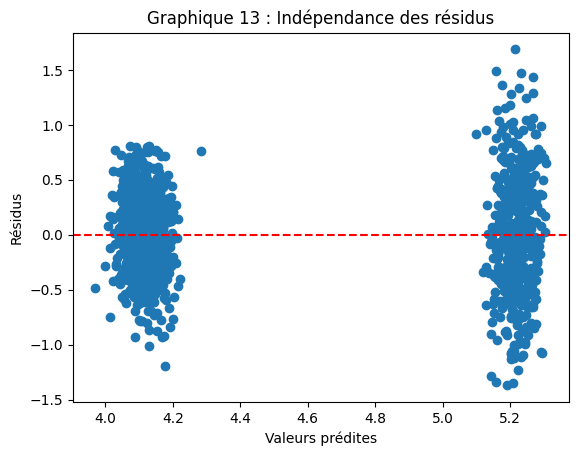

In [37]:
# Valeurs prédites par le modèle

fitted_values = reg_multi.fittedvalues

# Résidus/erreurs du modèle

residuals = reg_multi.resid

# Tracé du graphique des résidus

plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Graphique 13 : Indépendance des résidus')
plt.show()

## 4.La régression linéaire multiple


### 4.1 Prédiction des valeurs manquantes de "margin_low"

#### a. Entrainement du modèle sur le df sans VM

In [38]:
# Prédire 'margin_low' en fonction de 'is_genuine' et de 'margin_up'

# Les variables prédictives

X = billets_sansvm[['is_genuine', 'margin_up']]

# La variable cible, 'margin_low'

y = billets_sansvm.margin_low

In [39]:
# Entraînement du modèle sur les données avec la méthode fit
# Instancier le modèle

reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [40]:
# Evaluation du modèle : on obtient un score

print(f"R^2 : {np.round(reg.score(X, y), 3)}")

R^2 : 0.617


La documentation du modèle  LinearRegression  indique qu'il s'agit là du coefficient de détermination R^2 qui mesure les variations de la variable cible qui sont expliquées par le modèle. R^2 va de 0 (mauvais) à 1 (parfait).

R^2 mesure le pouvoir de prédiction des variables de la régression sur la variable cible, une valeur élevée indique une meilleure régression.

Comme il s'agit d'une régression linéaire, le modèle que nous venons d'entraîner s'exprime comme suit :

In [41]:
# Coefficients a et b de la régression linéaire

print(f" margin_low = {np.round(reg.coef_[0],  2)} * is_genuine + {np.round(reg.coef_[1],  2)} * margin_up  + du bruit")

 margin_low = -1.16 * is_genuine + -0.21 * margin_up  + du bruit


#### b. Prédiction de 'margin_low' sur le df avec VM

In [42]:
# Predictions des VM de "margin_low"

a_prevoir = billets_avecvm[['is_genuine','margin_up']]
billets_avecvm['margin_low'] = reg_multi.predict(a_prevoir)
billets_avecvm.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.074248,3.25,112.79
99,True,171.93,104.07,104.18,4.097561,3.14,113.08
151,True,172.07,103.80,104.38,4.122994,3.02,112.93
197,True,171.45,103.66,103.80,3.995830,3.62,113.27
241,True,171.83,104.14,104.06,4.122994,3.02,112.36


#### c. Concaténation des deux df

In [43]:
# DF final avec toutes les lignes

df_final = pd.concat([billets_sansvm, billets_avecvm])
df_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_pred,residual
0,True,171.81,104.86,104.95,4.52,2.89,112.83,4.150546,0.369454
1,True,171.46,103.36,103.66,3.77,2.99,113.09,4.129352,-0.359352
2,True,172.69,104.48,103.50,4.40,2.94,113.16,4.139949,0.260051
3,True,171.36,103.91,103.94,3.62,3.01,113.51,4.125114,-0.505114
4,True,171.73,104.28,103.46,4.04,3.48,112.54,4.025502,0.014498


In [44]:
# Suppression des colonnes pas très importantes

df_final = df_final.drop(columns=["margin_low_pred", "residual"])

In [45]:
# Informations sur le df concatené

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


In [46]:
# Description du df

df_final.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.482863,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659849,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


### 4.2 Regression linéaire multiple sur tout le dataframe final

In [47]:
# Méthode backward automatique

columns = ['margin_low', 'is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']
reg_backward = backward_selected(df_final[columns], 'margin_low')

_______________________________
margin_low ~ margin_up + diagonal + height_left + height_right + is_genuine + length + 1
remove length (p-value : 0.87 )

_______________________________
margin_low ~ margin_up + diagonal + height_left + height_right + is_genuine + 1
remove diagonal (p-value : 0.722 )

_______________________________
margin_low ~ margin_up + height_left + height_right + is_genuine + 1
remove height_right (p-value : 0.501 )

_______________________________
margin_low ~ margin_up + height_left + is_genuine + 1
remove height_left (p-value : 0.453 )

_______________________________
margin_low ~ margin_up + is_genuine + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     1229.
Date:                F

In [48]:
reg_multi2 = smf.ols('margin_low~margin_up+is_genuine', data=df_final).fit()
print(reg_multi2.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     1229.
Date:                Fri, 06 Sep 2024   Prob (F-statistic):          1.45e-316
Time:                        07:46:05   Log-Likelihood:                -775.59
No. Observations:                1500   AIC:                             1557.
Df Residuals:                    1497   BIC:                             1573.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.9263      0

Le R² ajusté est égal à 0.62, c’est le pourcentage de variation de la variable dépendante "margin_low" qui est expliqué par un modèle linéaire corrigé par le nombre de degrè de liberté.

### 4.3 Analyse des résultats : les hypothèses à vérifier

### a. Les leviers


Les leviers (leverages) sont des quantités qui mesurent l'influence de chaque observation sur les prédictions dans un modèle de régression multiple.  Les valeurs de levier sont calculées à partir de la matrice de projection 𝐻, en sachant que le seuil des leviers est de  2∗𝑝/𝑛.

In [49]:
# Réalisation du test à un niveau  𝛼=5 % :

alpha = 0.05

# Récupérons 𝑛, le nombre d'individus de l'échantillon, et 𝑝, le nombre de variables :

n = df_final.shape[0]
p = 3

# Création d'un df analyses avec une colonne 'obs'

analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

In [50]:
analyses['levier'] = reg_multi2.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

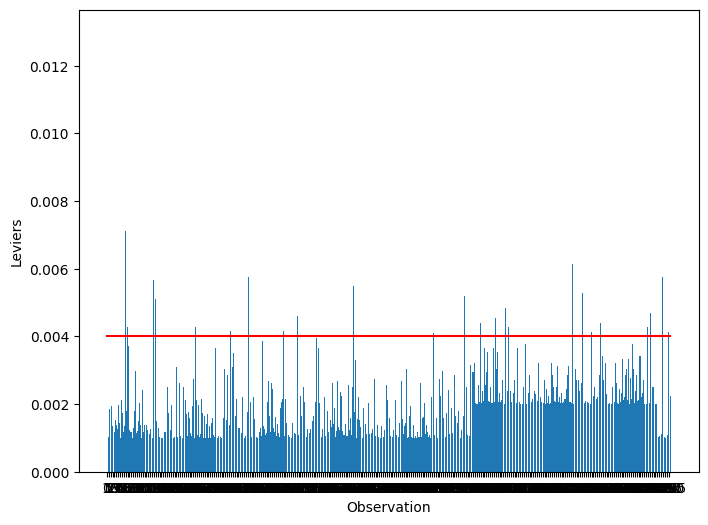

In [51]:
# Graphique 14

plt.figure(figsize=(8,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1500, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1500], [seuil_levier, seuil_levier], color='r')
plt.show()

In [52]:
# Sélectionner les points pour lesquels le levier est supérieur au seuil :

analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
4,5,0.004594
48,49,0.007109
52,53,0.010288
54,55,0.004265
123,124,0.005672
...,...,...
1466,1467,0.007330
1478,1479,0.005754
1488,1489,0.005375
1494,1495,0.004140


### b. Les résidus studentisés

Ils sont utilisés pour identifier les observations qui s'écartent significativement de la tendance globale du modèle : ils aident à détecter les points aberrants (outliers)

In [53]:
# Le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

analyses['residu_studentise'] = reg_multi2.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

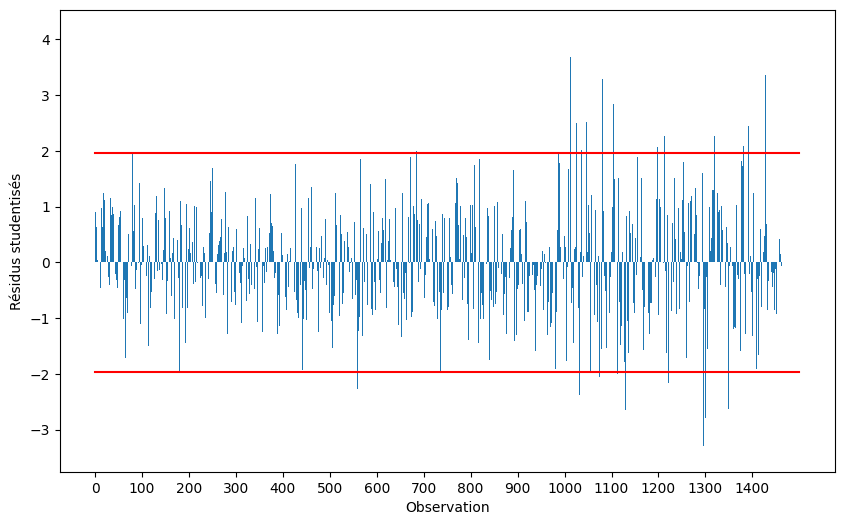

In [54]:
# Représentation graphique 15

plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['residu_studentise'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1500], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1500], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

In [55]:
# Définir les seuils

seuil_residu = 2  # Résidu studentisé seuil
seuil_levier = 2 * p / n  # Levier seuil

# Extraire les points aberrants potentiels
points_aberrants = analyses[(analyses['residu_studentise'].abs() > seuil_residu) | (analyses['levier'] > seuil_levier)]

print("Analyses:")
print(analyses)

print("\nPoints aberrants potentiels:")
print(points_aberrants)

print(f"\nSeuil de levier : {seuil_levier}")

Analyses:
       obs    levier  residu_studentise
0        1  0.001516       9.101975e-01
1        2  0.001076      -8.851167e-01
2        3  0.001247       6.405826e-01
3        4  0.001035      -1.244114e+00
4        5  0.004594       3.577397e-02
...    ...       ...                ...
1495  1496  0.005465       3.288727e-14
1496  1497  0.002049       3.064220e-14
1497  1498  0.003325       2.847168e-14
1498  1499  0.002864       3.065473e-14
1499  1500  0.002238       3.064511e-14

[1500 rows x 3 columns]

Points aberrants potentiels:
       obs    levier  residu_studentise
4        5  0.004594       3.577397e-02
10      11  0.001321      -2.288696e+00
48      49  0.007109      -7.113962e-01
52      53  0.010288      -1.188755e+00
54      55  0.004265      -1.967219e-01
...    ...       ...                ...
1466  1467  0.007330      -1.645907e-14
1478  1479  0.005754      -1.315682e-14
1488  1489  0.005375      -1.534670e-14
1494  1495  0.004140       3.067435e-14
1495  1496  0.0

### c.  La distance de Cook

Mesure utilisée pour évaluer l'influence d'une observation individuelle sur les résultats d'un modèle de régression. Elle combine à la fois l'impact de l'observation sur les valeurs ajustées et les résidus. Une distance de Cook élevée indique que l'observation a une influence importante sur le modèle et peut être considérée comme un point influent ou aberrant.

In [56]:
# Pour trouver la distance de Cook :

influence = reg_multi2.get_influence().summary_frame()

# Le seuil de la distance de Cook est de n-p.

analyses['distance_cook'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

# En général, une distance de Cook supérieure à 4/(n-p) est souvent considérée comme élevée

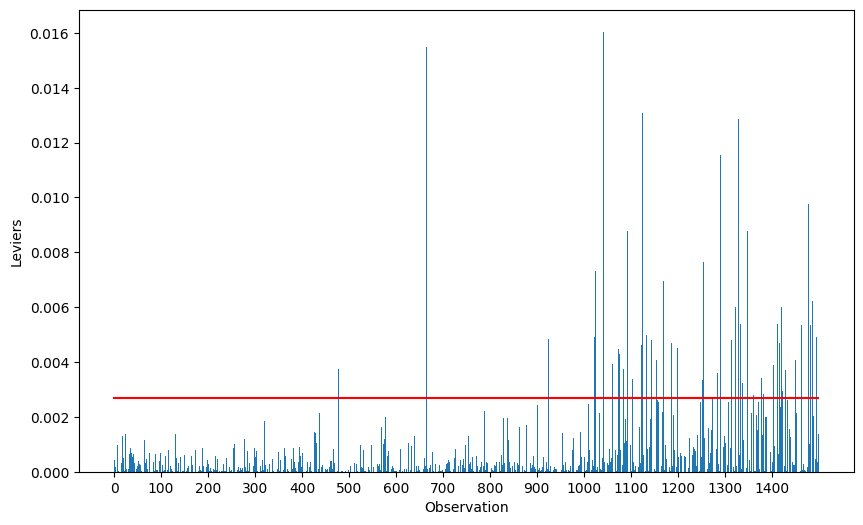

In [57]:
# Observations influentes : G16

plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['distance_cook'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1500], [seuil_dcook, seuil_dcook], color='r')
plt.show()

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.


In [58]:
# Extraire les points influents potentiels

points_influents = analyses[analyses['distance_cook'] > seuil_dcook]

print("Analyses:")
print(analyses)

print("\nPoints influents potentiels:")
print(points_influents)

print(f"\nSeuil de distance de Cook : {seuil_dcook}")

Analyses:
       obs    levier  residu_studentise  distance_cook
0        1  0.001516       9.101975e-01       0.000419
1        2  0.001076      -8.851167e-01       0.000281
2        3  0.001247       6.405826e-01       0.000171
3        4  0.001035      -1.244114e+00       0.000534
4        5  0.004594       3.577397e-02       0.000002
...    ...       ...                ...            ...
1495  1496  0.005465       3.288727e-14       0.004906
1496  1497  0.002049       3.064220e-14       0.000014
1497  1498  0.003325       2.847168e-14       0.000355
1498  1499  0.002864       3.065473e-14       0.000002
1499  1500  0.002238       3.064511e-14       0.001379

[1500 rows x 4 columns]

Points influents potentiels:
       obs    levier  residu_studentise  distance_cook
52      53  0.010288      -1.188755e+00       0.004896
125    126  0.001167       6.756299e-01       0.006567
239    240  0.001621      -2.180100e-01       0.005156
341    342  0.001651       1.146195e+00       0.003307


## 5.La regression logistique

Modélisation d'une variable qualitative par des variables explicatives.



### 5.1 Mise en place de la regression logistique

In [59]:
# Bibliothèque

from statsmodels.api import Logit
from statsmodels.discrete.discrete_model import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import cluster, metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [60]:
# Retrait des variables non significatives par la méthode Backward

reg_logistiq = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length',
                   data=df_final, family=sm.families.Binomial()).fit()
print(reg_logistiq .summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1493
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -39.487
Date:                                       Fri, 06 Sep 2024   Deviance:                       78.975
Time:                                               07:46:16   Pearson chi2:                 2.80e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7049
Covariance Type:                                   nonrobust                      

In [61]:
# Nouvelle itération

reg_logistiq = smf.glm('is_genuine~height_left+height_right+margin_low+margin_up+length',
                   data=df_final, family=sm.families.Binomial()).fit()
print(reg_logistiq .summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1494
Model Family:                                       Binomial   Df Model:                            5
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -39.515
Date:                                       Fri, 06 Sep 2024   Deviance:                       79.031
Time:                                               07:46:16   Pearson chi2:                 2.80e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7049
Covariance Type:                                   nonrobust                      

In [62]:
# Nouvelle itération

reg_logistiq = smf.glm('is_genuine~height_right+margin_low+margin_up+length',
                   data=df_final, family=sm.families.Binomial()).fit()
print(reg_logistiq .summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1495
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -40.175
Date:                                       Fri, 06 Sep 2024   Deviance:                       80.351
Time:                                               07:46:16   Pearson chi2:                 3.42e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7046
Covariance Type:                                   nonrobust                      

Il s’agira de prédire la variable « is_genuine » en fonction des 4 variables explicatives « height_right », « margin_up », « margin_low » et « length ».

Scinder mon dataset en 2 dataset bien distincts, 80%train et 20%test, et après avoir défini mes variables, créer le modèle de régression logistique, que j’applique sur mes données.
Ensuite j’évalue la performance du modèle.


In [63]:
# Valeurs caractéristiques et valeur cible

x = df_final [['height_right','margin_low','margin_up','length']]
y = df_final['is_genuine']

In [64]:
# Séparation du dataset en 2 : TRAIN (80%) et TEST (20%)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,
                                                    random_state=1)
y_test.size

300

In [65]:
# Modèle de régression logistique

clf = LogisticRegression(random_state = 42)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [66]:
# Minimiser le biais du modèle

clf.score(x_train, y_train)

0.9916666666666667

In [67]:
clf.score(x_test, y_test)

0.9833333333333333

###  5.2 Evaluation de la performance du modèle de classification

#### a. La Matrice de confusion

La matrice de confusion nous donne des informations sur la performance de prediction du modèle.


In [68]:
y_pred = clf.predict(x_test)
y_proba = clf.predict_proba(x_test)

In [69]:
# La matrice de confusion

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 92,   4],
       [  1, 203]])

In [70]:
# Comptage

y_test.value_counts()

,count
is_genuine,
True,204
False,96


Text(0.5, 1.0, 'Graphique 17 : Matrice de confusion de la régression logistique\n')

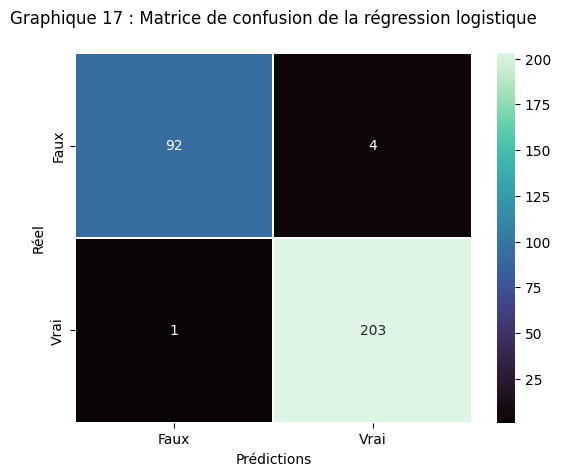

In [71]:
# Représentation graphique avec labels

sns.heatmap(cnf_matrix,
            annot = True,
            fmt = ".3g",

       cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Graphique 17 : Matrice de confusion de la régression logistique\n")

Sur les 96 faux billets, 92 ont été correctement prédit(vrais négatifs) soit un taux de prediction de 95,83%.

Les vrais billets qui ont éte correctement classés est de 203 sur les 204 vrais billets de l'echantillon.

Le nombre de faux positif ou le vrais billets de banque qui ont été classifiés comme faux est de 1

Le nombre de faux négatifs ou les faux billets de banque qui ont été classés comme vrai par le modèle est de 4.

#### b. Les Metrics

À partir des métriques TP, TN, FP, FN, on définit de nombreuses métriques adaptées à des problématiques et des interprétations spécifiques, dont l' “Exactitude”, la “précision” et le “rappel”.

* Exactitude = accuracy = échantillons bien classés / échantillons au total

C'est la capacité du modèle à faire de bonnes prédictions.

* La précision (Precision) = TP / (TP + FP)
La précision est adaptée quand on souhaite minimiser les faux positifs.Un modèle avec une forte précision réduit les risques de fausses alertes.
C'est la part des enregistrements réellement positifs(vrais billets) sur les enregistrements positifs prédits.

* Le rappel (Recall) = TP / (TP + FN) (recall en anglais)
Le rappel est adapté pour minimiser les faux négatifs, quand les conséquences de manquer des instances positives sont graves. Un modèle avec un fort rappel réduit les risques de rater une détection souhaitée. C'est la part des vrais billets correctement predits sur le nombre total de vrais billet ou Couverture des observations vraiment positives.



In [72]:
# Quelques critères d'évaluation du modèle

from sklearn.metrics import precision_score, recall_score

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
#print("Score F1:",F1_score(y_test, y_pred))

Accuracy: 0.9833333333333333
Precision: 0.9806763285024155
Recall: 0.9950980392156863


#### c. Courbe ROC et score AUC

La Courbe ROC ou courbe sensibilité/spécificité, qui permet d’évaluer la qualité prédictive du modèle, en nous montrant le taux de vrais positifs en fonction du taux de faux positifs. On a un AUC de 1, ce qui représente un classificateur parfait, très satisfaisant.

Receiver Operating Characteristic (ou ROC), ou encore fonction d’efficacité du récepteur.

Il s'agit de tracer le rappel ou TPR (true positive rate) par rapport au FPR (false positive rate) en fonction des seuils de classification. Le TPR est défini par TP / (TP + FN) et le FPR est défini par FP /(FP + TN)


Encore appelée courbe sensibilité/spécificité, c'est une mesure de la performance d'un classificateur binaire. Graphiquement, on représente souvent la mesure ROC sous la forme d'une courbe qui donne le taux de vrais positifs en fonction du taux de faux positifs.

Un score AUC (aire sous la courbe) de 1 représente un classificateur parfait, tandis qu'un score de 0.5 représente un classificateur inutile.

In [73]:
# Evaluation de la qualité prédictive du modèle : Train/ Tracer True positive rate par rapport à False positive rate

model = LinearRegression()
result = model.fit(x_train, y_train)
y_pred = result.predict(x_train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred)
roc_auc_train = auc(fpr_train, tpr_train)

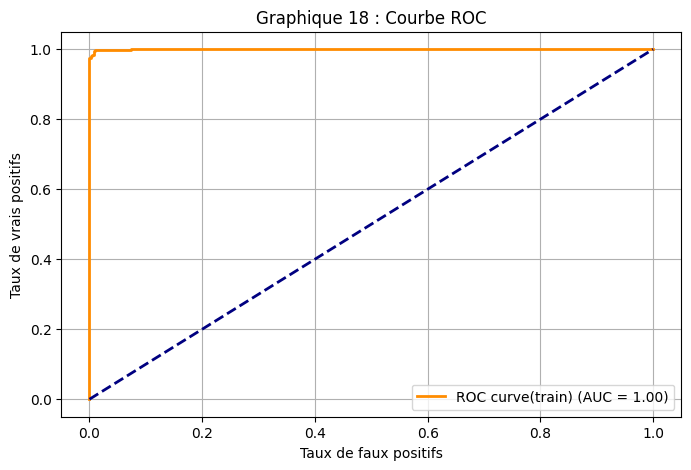

In [74]:
# Courbe ROC et les aires sous la courbe (AUC)

plt.figure(figsize=(8,5))
plt.plot(fpr_train, tpr_train, color ='darkorange', lw=2, label='ROC curve(train) (AUC = %0.2f)' %roc_auc_train)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Graphique 18 : Courbe ROC')
plt.legend(loc ="lower right")
plt.grid()
plt.show()

## 6.Apprentissage non suppervisé

### 6.1 L'ACP

In [75]:
# Transformation de type de "is_genuine", 'bool' en 'int', soit "True" et "False" en "0" et "1"

df_final['is_genuine'].replace([False,True], [0,1], inplace=True)
df_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [76]:
# Types

df_final.dtypes

,0
is_genuine,int64
diagonal,float64
height_left,float64
height_right,float64
margin_low,float64
margin_up,float64
length,float64


In [77]:
# Normalisation des données

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Transformation en array Numpy

X = df_final.values

# Standardiser les données

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

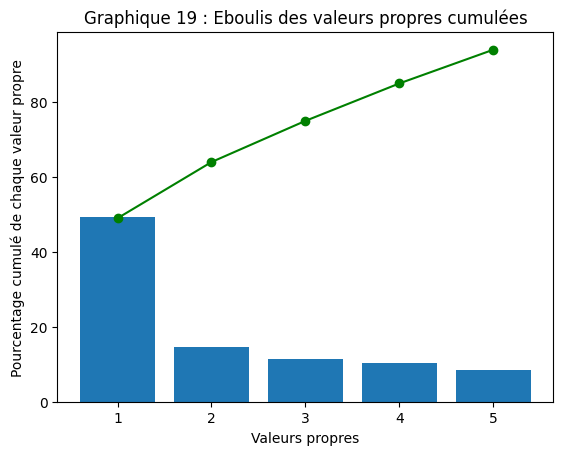

In [78]:
# Eboulis des valeurs propres

n_components = 5
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

# pca.explained_variance_ratio_

scree = (pca.explained_variance_ratio_*100).round(2)

scree_cum = scree.cumsum().round()

x_list = range(1, n_components+1)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="green",marker='o')
plt.xlabel("Valeurs propres")
plt.ylabel("Pourcentage cumulé de chaque valeur propre")
plt.title("Graphique 19 : Eboulis des valeurs propres cumulées")
plt.show(block=False)

In [79]:
# Calcul des premières composantes principales
# Pourcentage de variance expliquée

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.49213233 0.14571517 0.11275362 0.10229614 0.08507663]
0.9379738900492124


Le pourcentage de variance expliquée par chacune des composantes : Les 2 premières composantes expliquent environ 64% de la variance observée dans les données.

Cherchons à visualiser nos données sur les 2 premières composantes principales, afin d'avoir une première vue sur une base orthonormée (en 2D).

In [80]:
# Contribution de chaque variable aux composantes

features = ['is_genuine', 'margin_low', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']

In [81]:
def correlation_graph(pca,
                      x_y,
                      features) :
# Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(9, 7))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('PC{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('PC{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
    plt.title("Graphique 20 : Cercle des corrélations (PC{} et PC{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))
   # Axes et display
    plt.axis('equal')
    plt.show(block=False)

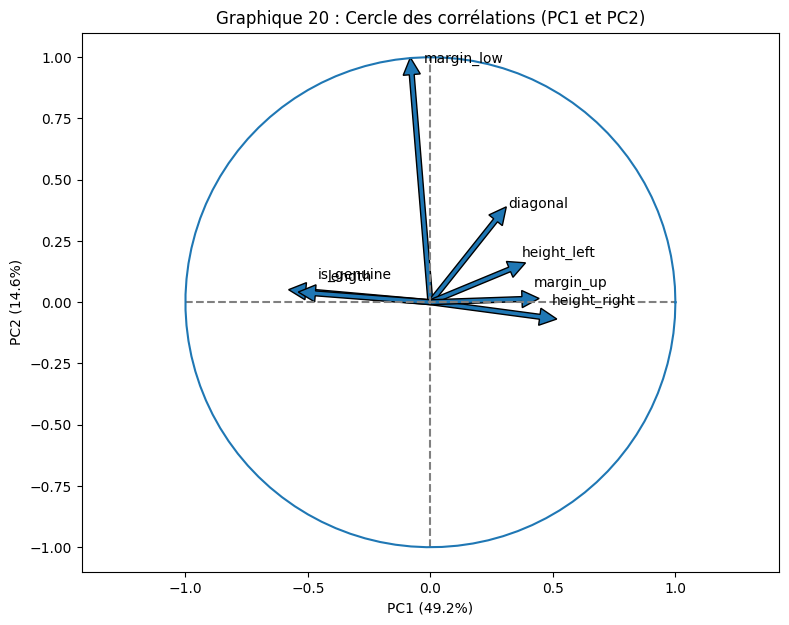

In [82]:
# PC1 et PC2 (~ 50%)

correlation_graph(pca, (0,1), features)

In [83]:
# Corrélation PCP et variables

t=pca.components_[:]
df_corr_comp = pd.DataFrame(t, index=[f'PC{i+1}' for i in range(t.shape[0])], columns=features)
df_corr_comp.head()

,is_genuine,margin_low,diagonal,height_left,height_right,margin_up,length
PC1,-0.509038,-0.076185,0.266173,0.323535,0.446413,0.373833,-0.469592
PC2,0.045018,0.929034,0.334538,0.133978,-0.059397,0.012877,0.036193
PC3,0.097420,-0.327802,0.891874,-0.044876,-0.095836,-0.236863,0.142522
PC4,0.086599,-0.099050,-0.119175,0.912516,-0.076800,-0.328127,0.149116
PC5,-0.143248,0.113621,-0.077900,-0.195408,0.476517,-0.802170,-0.227535


### 6.2 Le KMeans

In [84]:
from sklearn import preprocessing
np.random.seed(808)
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
pd.options.mode.chained_assignment = None

Créer un dataset artificiel en 2 dimensions constitué de K clusters de N échantillons chacun, scikit-learn offre la fonction make_blob().

Par exemple voici 2 "blobs" bien séparés constitués de 1500 échantillons chacun n_samples=1500, centrés respectivement aux coordonnées centers = [[1, 0], [0, -1]] et d'écart type cluster_std=0.7

In [85]:
from sklearn.datasets import make_blobs

centers = [[1, 0], [0, -1]]
X, labels_true = make_blobs(
                      n_samples=1500,
                      centers=centers,
                      cluster_std=0.7)

In [86]:
# Dimension 1500 x 2

X.shape

(1500, 2)

In [87]:
labels_true

array([0, 1, 0, ..., 0, 1, 0])

In [88]:
# De dimension 1500

len(labels_true)

1500

In [89]:
k_means = KMeans( n_clusters=2, random_state = 42, n_init = 'auto')
k_means.fit(X)
print(k_means.cluster_centers_)

[[ 1.03154408  0.07979201]
 [-0.07865099 -1.13131228]]


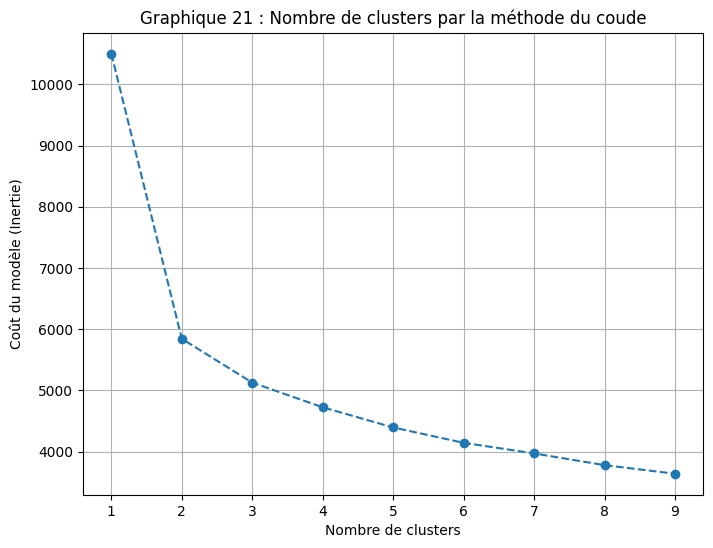

In [90]:
# Recherche du nombre de clusters par la méthode du coude

inertia = []
k_range = range(1, 10)
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertia.append(model.inertia_)

# Affichage du graphique de la méthode du coude
fig = plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coût du modèle (Inertie)')
plt.title('Graphique 21 : Nombre de clusters par la méthode du coude')
plt.grid(True)
plt.show()

On peut dire qu'à 2 clusters, l'ajout de clusters supplémentaires n'apporte plus de gain significatif en termes de réduction de l'inertie.

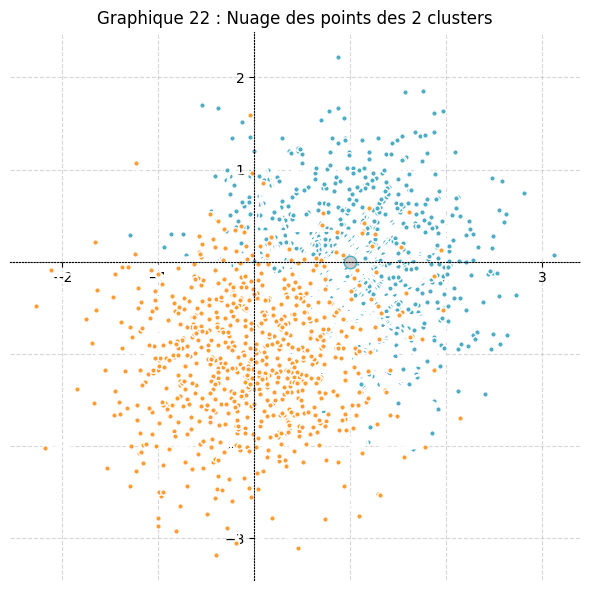

<Figure size 640x480 with 0 Axes>

In [91]:
# Visualisations

centers = [[1, 0], [0, -1]]
X, labels_true = make_blobs(n_samples=1500, centers=centers, cluster_std=0.7)
n_clusters = len(centers)
fig = plt.figure(figsize=(6, 6))
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

ax = fig.add_subplot(1, 1, 1)

ax.set_title("Graphique 22 : Nuage des points des 2 clusters")

for k, col in zip(range(len(centers)), colors):
    my_members = labels_true == k
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker="o", markersize=4, alpha = 1)
for k, col in zip(range(len(centers)), colors):
    ax.plot(
         centers[k][0],
         centers[k][1],
         "o",
         markerfacecolor='#CCC',
         markeredgecolor=col,
        markersize=9,
        )
    # ax.set_title("Original")
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_linestyle('dotted')
    ax.spines['left'].set_linestyle('dotted')

    # Customize the appearance of grid lines (dotted and alpha=0.5)
    ax.xaxis.grid(True, linestyle='--', alpha=0.5)
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

On obtient 2 nuages de points bien distincts.

In [92]:
# Appliquons maintenant l'algorithme du k-means sur ces 2 nuages de points.

from sklearn.cluster import KMeans
k_means = KMeans( n_clusters=2, random_state = 808)
k_means.fit(X)
print(k_means.cluster_centers_)

[[ 1.0841787   0.06435796]
 [-0.13052729 -1.14461552]]


In [93]:
from sklearn import decomposition
from sklearn.cluster import KMeans

# librairies de l'ACP
from sklearn.decomposition import PCA

# librairie pour la sauvegarde du modèle
import joblib
from joblib import dump, load

# Options globales pour l'output display:

pd.options.display.float_format = "{:.3f}".format

# Nombre de clusters:

n_clust = 2

# Clustering par K-means:

km = KMeans(n_clusters=n_clust,random_state=1994)
x_km = km.fit_transform(df_final[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

In [94]:
# Ajout d'une colonne contenant le cluster attribue :

clusters_km = km.labels_
df_final["cluster_km"] = km.labels_
df_final["cluster_km"] = clusters_km
df_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_km
0,1,171.810,104.860,104.950,4.520,2.890,112.830,0
1,1,171.460,103.360,103.660,3.770,2.990,113.090,0
2,1,172.690,104.480,103.500,4.400,2.940,113.160,0
3,1,171.360,103.910,103.940,3.620,3.010,113.510,0
4,1,171.730,104.280,103.460,4.040,3.480,112.540,0


[[171.98684366 103.95183874 103.81357915   4.12270846   3.05818092
  113.1953294 ]
 [171.89863354 104.19312629 104.14503106   5.24120064   3.3479089
  111.59026915]]


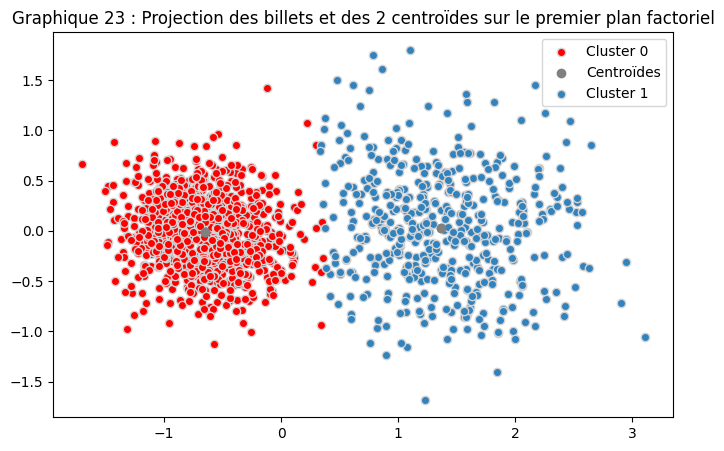

In [95]:
# Clustering par projection des individus sur le premier plan factoriel :

centroids_km = km.cluster_centers_
print(centroids_km)
pca_km = decomposition.PCA(n_components=3).fit(df_final[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
acp_km = PCA(n_components=3).fit_transform(df_final[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

centroids_km_projected = pca_km.transform(centroids_km)

# Graphique:

plt.figure(figsize=(8, 5))
colormap = np.array(['red', 'blue'])
for couleur,k in zip(['red', "#3182bd"],[0,1]):
    plt.scatter(acp_km[km.labels_==k,0],acp_km[km.labels_==k,1],c=couleur,edgecolors="#D3D3D3",label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="grey",label="Centroïdes")
plt.title("Graphique 23 : Projection des billets et des {} centroïdes sur le premier plan factoriel".format(len(centroids_km)))
plt.show()

### 6.3 Matrice de confusion avec k-means

In [96]:
tableau = pd.crosstab(clusters_km,df_final["is_genuine"])
tableau.index = ['Cluster 0','Cluster 1']
tableau.columns = ['Faux_billets','Vrai_billets']
tableau

,Faux_billets,Vrai_billets
Cluster 0,19,998
Cluster 1,481,2


Text(0.5, 1.0, 'Graphique 24 : Matrice de confusion K_means\n')

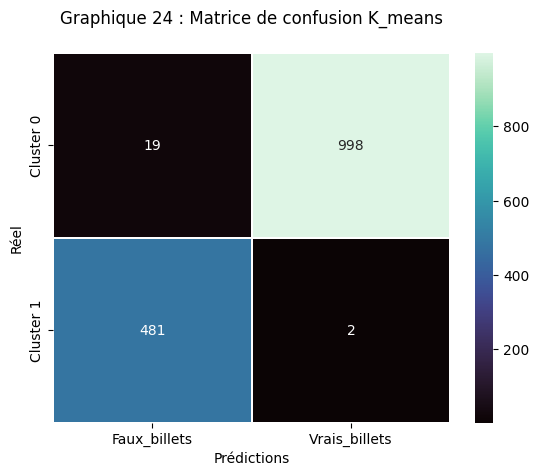

In [97]:
# Carte de chaleur

sns.heatmap(tableau,
            annot = True,
            fmt = ".3g",

       cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux_billets","Vrais_billets"],
            yticklabels=["Cluster 0","Cluster 1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Graphique 24 : Matrice de confusion K_means\n")

### 6.4 Evaluation du modèle

In [98]:
accuracy=round(((481+998)/1500)*100,2)
precision=round((998/(998+19))*100,2)
recall=round((998/(2+998))*100,2)
vrai_négatif=round((481/500)*100,2)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Vrai négatif:", vrai_négatif)

Accuracy: 98.6
Precision: 98.13
Recall: 99.8
Vrai négatif: 96.2


Le format type de nos fichiers de
billets avec lequel l’algorithme est censé fonctionner est celui du fichier test billets_production.csv

Il faudra mettre en concurrence les deux méthodes de
prédiction :

● la régression logistique classique ;

● le k-means, duquel seront utilisés les centroïdes pour réaliser la prédiction.

## 7.Comparaison des scores des 2 méthodes de prédiction

In [99]:
# Remplacez ces valeurs par les scores réels

# Scores
reg_log_scores = [0.983, 0.980, 0.995]  # Pour la régression logistique
km_scores = [0.986, 0.981, 0.998]       # Pour KMeans

# Noms des méthodes
methods = ['Logistic Regression', 'KMeans']
index = ['Accuracy', 'Precision', 'Recall']

# Création du DataFrame
df = pd.DataFrame(index=index, columns=methods)
df['Logistic Regression'] = reg_log_scores
df['KMeans'] = km_scores

# Trouver le score max
max_acc = df.loc['Accuracy'].max()
max_prec = df.loc['Precision'].max()
max_recall = df.loc['Recall'].max()

# Afficher le DataFrame
print(df)
print("\nMax Accuracy:", max_acc)
print("Max Precision:", max_prec)
print("Max Recall:", max_recall)


           Logistic Regression  KMeans
Accuracy                 0.983   0.986
Precision                0.980   0.981
Recall                   0.995   0.998

Max Accuracy: 0.986
Max Precision: 0.981
Max Recall: 0.998


Etant donné qu’on est en dans le cadre des algorithmes supervisés du machine learning, nous allons utiliser la régression logistique pour prédire le type de billets du fichier test « billets_production.csv ».

## 8.Prédiction avec la regression logistique

In [100]:
# Appliquer le modèle sur le jeu de test

df_test = pd.read_csv("billets_production.csv", sep=',')
df_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.760,104.010,103.540,5.210,3.300,111.420,A_1
1,171.870,104.170,104.130,6.000,3.310,112.090,A_2
2,172.000,104.580,104.290,4.990,3.390,111.570,A_3
3,172.490,104.550,104.340,4.440,3.030,113.200,A_4
4,171.650,103.630,103.560,3.770,3.160,113.330,A_5


In [101]:
# Sélection des features

x = df_test[['height_right', 'margin_low', 'margin_up', 'length']]

In [102]:
# Prédiction

prediction = clf.predict(x)
prediction

array([False, False, False,  True,  True])

In [103]:
# Ajouter les prédictions comme nouvelle colonne dans df_test

df_test['prediction'] = prediction
df_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction
0,171.760,104.010,103.540,5.210,3.300,111.420,A_1,False
1,171.870,104.170,104.130,6.000,3.310,112.090,A_2,False
2,172.000,104.580,104.290,4.990,3.390,111.570,A_3,False
3,172.490,104.550,104.340,4.440,3.030,113.200,A_4,True
4,171.650,103.630,103.560,3.770,3.160,113.330,A_5,True


# Conclusion :
L’objectif visé par l’équipe data a été atteint, car j’ai utilisé la régression linéaire multiple pour remplir les valeurs manquantes de notre dataset,

J’ai prédit le type de billet avec une exactitude de 98,33 % avec la régression logistique en Apprentissage supervisé, et 98,6% avec le KMeans en Apprentissage non supervisé.


# Ce projet marque la fin de mon parcours de formation "Data analyst" !

Il n'aurait pas été possible sans l'équipe OC, sans le concours de mes promotionnaires, et surtout sans la région IDF!
Un merci particulier va à l'endroit de mon Mentor, M. M. Ankarali, qui n'a ménagé aucun effort pour m'accompagner aucours de cette formation, et s'est montré toujours disponible quand je le sollicitais.

Merci à tous !